# SHAP explanations

In [1]:
import trustyai

trustyai.init()

## Simple example

We start by defining our black-box model, typically represented by

$$
f(\mathbf{x}) = \mathbf{y}
$$

Where $\mathbf{x}=\{x_1, x_2, \dots,x_m\}$ and $\mathbf{y}=\{y_1, y_2, \dots,y_n\}$.

Our example toy model, in this case, takes an all-numerical input $\mathbf{x}$ and return a $\mathbf{y}$ of either `true` or `false` if the sum of the $\mathbf{x}$ components is within a threshold $\epsilon$ of a point $\mathbf{C}$, that is:

$$
f(\mathbf{x}, \epsilon, \mathbf{C})=\begin{cases}
\text{true},\qquad \text{if}\ \mathbf{C}-\epsilon<\sum_{i=1}^m x_i <\mathbf{C}+\epsilon \\
\text{false},\qquad \text{otherwise}
\end{cases}
$$

This model is provided in the `TestUtils` module. We instantiate with a $\mathbf{C}=500$ and $\epsilon=1.0$.

In [2]:
from trustyai.utils import TestUtils

center = 10.0
epsilon = 2.0

model = TestUtils.getSumThresholdModel(center, epsilon)

Next we need to define a **goal**.
If our model is $f(\mathbf{x'})=\mathbf{y'}$ we are then defining our $\mathbf{y'}$ and the counterfactual result will be the $\mathbf{x'}$ which satisfies $f(\mathbf{x'})=\mathbf{y'}$.

We will define our goal as `true`, that is, the sum is withing the vicinity of a (to be defined) point $\mathbf{C}$. The goal is a list of `Output` which take the following parameters

- The feature name
- The feature type
- The feature value (wrapped in `Value`)
- A confidence threshold, which we will leave at zero (no threshold)

In [3]:
from trustyai.model import output

decision = "inside"
goal = [output(name=decision, dtype="bool", value=True, score=0.0)]

We will now define our initial features, $\mathbf{x}$. Each feature can be instantiated by using `FeatureFactory` and in this case we want to use numerical features, so we'll use `FeatureFactory.newNumericalFeature`.

In [4]:
import random
from trustyai.model import feature

features = [feature(name=f"x{i+1}", dtype="number", value=random.random()*10.0) for i in range(3)]

As we can see, the sum of of the features will not be within $\epsilon$ (1.0) of $\mathbf{C}$ (500.0). As such the model prediction will be `false`:

In [ ]:
feature_sum = 0.0
for f in features:
    value = f.value.as_number()
    print(f"Feature {f.name} has value {value}")
    feature_sum += value
print(f"\nFeatures sum is {feature_sum}")

We execute the model on the generated input and collect the output

In [6]:
from org.kie.kogito.explainability.model import PredictionInput, PredictionOutput

goals = model.predictAsync([PredictionInput(features)]).get()

In [7]:
background = []
for i in range(10):
    _features = [feature(name=f"x{i+1}", dtype="number", value=random.random()*10.0) for i in range(3)]
    background.append(PredictionInput(_features))

We wrap these quantities in a `SimplePrediction`:

In [8]:
from trustyai.model import simple_prediction

prediction = simple_prediction(input_features=features, outputs=goals[0].outputs)

We can now instantiate the **explainer** itself.


In [9]:
from trustyai.explainers import SHAPExplainer

explainer = SHAPExplainer(background=background)

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


We generate the **explanation** as a _dict : decision --> saliency_.


In [10]:
explanation = explainer.explain(prediction, model)

We inspect the saliency scores assigned by LIME to each feature

In [11]:
for saliency in explanation.getSaliencies():
    print(saliency)

Saliency{output=Output{value=false, type=boolean, score=-2.227134955433277, name='inside'}, perFeatureImportance=[FeatureImportance{feature=Feature{name='x1', type=number, value=9.065199414996005}, score=-0.24999999999999994, confidence= +/-0.2776445105018461}, FeatureImportance{feature=Feature{name='x2', type=number, value=4.043144332752045}, score=0.04999999999999999, confidence= +/-0.2776445105018461}, FeatureImportance{feature=Feature{name='x3', type=number, value=0.11879120768522489}, score=0.09999999999999995, confidence= +/-0.3926486322701499}]}


# Python Models
Now let's go over how to use a Python model with TrustyAI. First, let's grab a dataset, we'll use the California Housing dataset from `sklearn`, which tries
to predict the median house value of various California housing districts given a number of different attributes of the district.

After downloading the dataset, we then split it into train and test splits.

In [39]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X, y = sklearn.datasets.fetch_california_housing(data_home="data", return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
print(f"X Train: {X_train.shape}, X Test: {X_test.shape}, Y Train: {y_train.shape}, Y Test: {y_test.shape}")

X Train: (16512, 8), X Test: (4128, 8), Y Train: (16512,), Y Test: (4128,)


Now let's grab our model, just a simple xgboost regressor. We'll then plot its test predictions against the the true test labels, to see how well it does.

Test MSE 0.8299872000431893


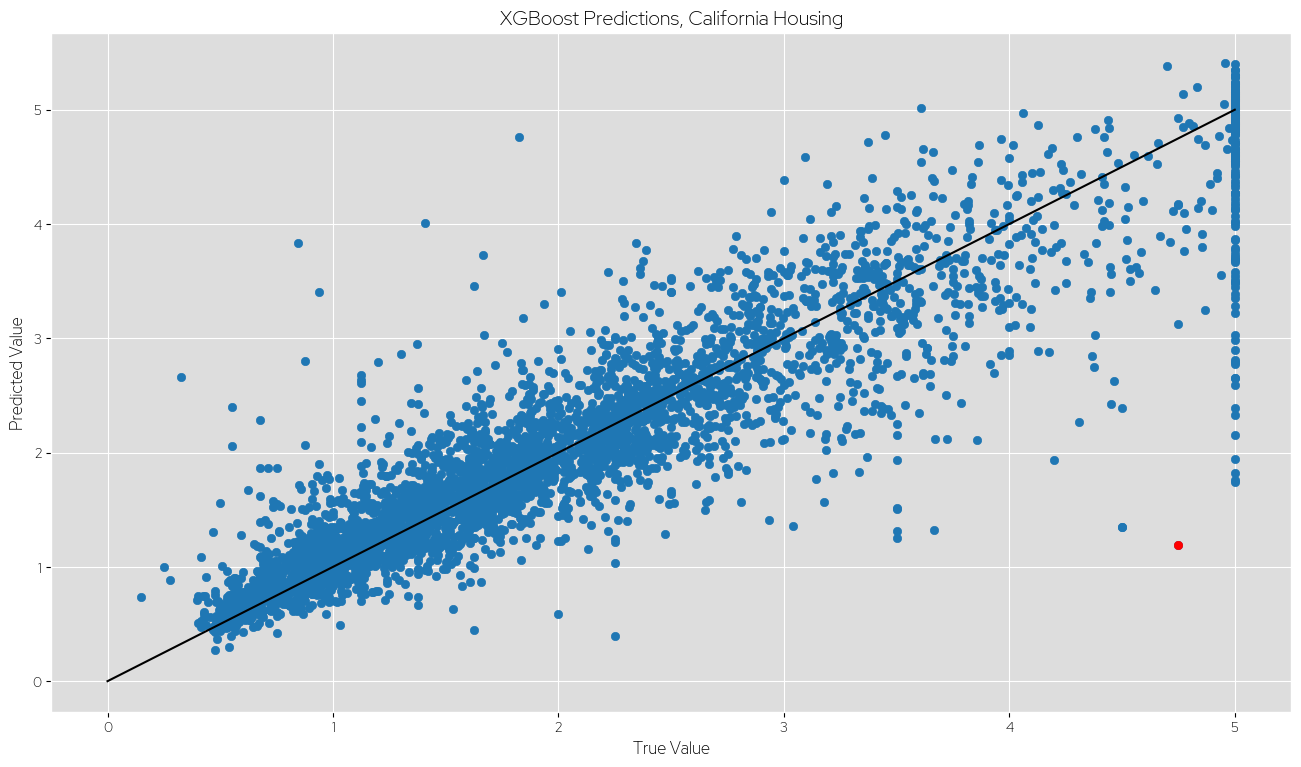

In [75]:
import xgboost
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('https://raw.githubusercontent.com/RobGeada/stylelibs/main/material_rh.mplstyle')

# uncomment to train from scratch
# xgb_model = xgboost.XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist')
# xgb_model.fit(X_train, y_train)
# print('Test MSE', xgb_model.score(X_test, y_test))
# xgb_model.save_model("models/california_xgboost")
 
# load and score model
xgb_model = xgboost.XGBRegressor(objective='reg:squarederror')
xgb_model.load_model("models/california_xgboost")
print('Test MSE', xgb_model.score(X_test, y_test))

# grab predictions and find largest error
predictions = xgb_model.predict(X_test)
worst = np.argmax(np.abs(predictions - y_test))

# plot predictions
plt.scatter(y_test, predictions)
plt.scatter(y_test.iloc[worst], predictions[worst], color='r')
plt.plot([0,5], [0,5], color='k')
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.title("XGBoost Predictions, California Housing")
plt.show()

That's pretty decent! Let's grab a point to explain; let's choose that really erroneous point marked in red in the above plot.

In [87]:
point_to_explain = X_test.iloc[worst]
point_to_explain

MedInc          3.729200
HouseAge        6.000000
AveRooms        4.583333
AveBedrms       1.083333
Population     69.000000
AveOccup        2.875000
Latitude       37.800000
Longitude    -121.290000
Name: 16556, dtype: float64

We'll need to convert it into a Prediction object in order to pass it to the SHAP Explainer.

In [100]:
from trustyai.model import feature, output
features_to_explain = [feature(name=key, dtype='number', value=value) for key, value in point_to_explain.items()]
output_to_explain = output(name='Median House Price', dtype='number', value=predictions[worst])
prediction_to_explain = simple_prediction(input_features=features_to_explain, outputs=[output_to_explain])

We also need to convert our training data into TrustyAI PredictionInputs. This is pretty simple for Pandas DataFrames:

In [101]:
from org.kie.kogito.explainability.model import PredictionInput

X_train_PIs = [PredictionInput([feature(name=key, dtype='number', value=value) for key, value in x.items()]) for _, x in X_train.iterrows()]

Now we can wrap our model into a TrustyAI PredictionProvider. We do this via an `ArrowModel`, which rapidly speeds up the data transfer between Python and the TrustyAI Java library. 
To create an ArrowModel, we need to pass it a function that accepts a Pandas DataFrame as input and outputs a Pandas DataFrame or Numpy Array. All sklearn models satisfy this with their
`predict` or `predict_proba` functions, so this is really easy to do.

We then call the `get_as_prediction_provider`
function on the ArrowModel, to which we pass an example datapoint to use as a template for our data conversions. Make sure this template point has the same schema (i.e., feature names and types) as all the other points you plan on passing to the model!

In [102]:
from trustyai.model import ArrowModel
trustyai_model = ArrowModel(xgb_model.predict).get_as_prediction_provider(X_train_PIs[0])

With our model successfully wrapped, we can create our SHAP explainer. To do this we need to specify a *background dataset*, a small $(\le100)$ set of representative examples of the model's input. We'll use the first 100 training points as our background dataset. 

In [103]:
from trustyai.explainers import SHAPExplainer
explainer = SHAPExplainer(background=X_train_PIs[:100])

We can now produce our explanation:

In [293]:
explanations = explainer.explain(prediction_to_explain, trustyai_model)

## Visualizing SHAP Values

Now let's visualize the explanation, first as a dataframe:

(the `visualize_explanation` function will be included into the trustyai module in a future release)

In [353]:
import pandas as pd
from IPython.display import display
from matplotlib.colors import  LinearSegmentedColormap

def visualize_explanations_as_text(explanation, background):
    def color_feature_values(feature_vals, background_vals):
        formats = []
        for i, x in enumerate(feature_vals[1:-1]):
            if x<background_vals[i]:
                formats.append("background-color:#ee0000")
            elif x>background_vals[i]:
                formats.append("background-color:#13ba3c")
            else:
                formats.append(None)
        return [None] + formats + [None]

    cmap = LinearSegmentedColormap.from_list(name='rwg', colors=['#ee0000', "#ffffff","#13ba3c"])
    
    for i, saliency in enumerate(explanation.getSaliencies()):
        background_mean_f_vals = np.mean([[f.getValue().asNumber() for f in pi.getFeatures()] for pi in background], 0).tolist()
        f_vals = [pfi.getFeature().getValue().asNumber() for pfi in saliency.getPerFeatureImportance()]
        shap_vals = [pfi.getScore() for pfi in saliency.getPerFeatureImportance()]
        feature_names = [str(pfi.getFeature().getName()) for pfi in saliency.getPerFeatureImportance()]
        columns = ['Mean Background Value', 'Feature Value', 'SHAP Value']
        df = pd.DataFrame([background_mean_f_vals, f_vals, shap_vals], index=columns, columns=feature_names).T
        fnull = explanation.getFnull().getEntry(i)
        background_row = pd.DataFrame([["-","-",fnull]], index=['Background'], columns=columns)
        prediction_row = pd.DataFrame([[fnull,sum(shap_vals) + fnull,sum(shap_vals) + fnull]], index=['Prediction'], columns=columns)
        df = pd.concat([background_row, df, prediction_row])

        slices = (slice(feature_names[0],feature_names[-1]), 'SHAP Value')
        vmin, vmax = -1*max(np.abs(shap_vals)), max(np.abs(shap_vals))
        style = df.style.background_gradient(cmap, subset=slices, vmin=vmin, vmax=vmax)
        display(style.apply(color_feature_values, background_vals=background_mean_f_vals, subset='Feature Value', axis=0))
    

visualize_explanations_as_text(explanations, X_train_PIs[:100])

,Mean Background Value,Feature Value,SHAP Value
Background,-,-,2.043139
MedInc,3.886537,3.729200,-0.184139
HouseAge,27.080000,6.000000,-0.009059
AveRooms,5.511316,4.583333,-0.162950
AveBedrms,1.073329,1.083333,-0.025911
Population,1512.940000,69.000000,0.092056
AveOccup,2.999465,2.875000,-0.018061
Latitude,36.164700,37.800000,-0.642149
Longitude,-119.898300,-121.290000,0.100729
Prediction,2.043139,1.193654,1.193654


Feature values in red/green indicate a lower/higher value than the average background value of that feature. SHAP values in red/green indicate a negative/positive contribution to the prediction.

Now let's visualize the explanation as a candlestick plot:

(Again, the `visualize_explanations_as_candlestick` function will be bundled into the TrustyAI module in a later update)

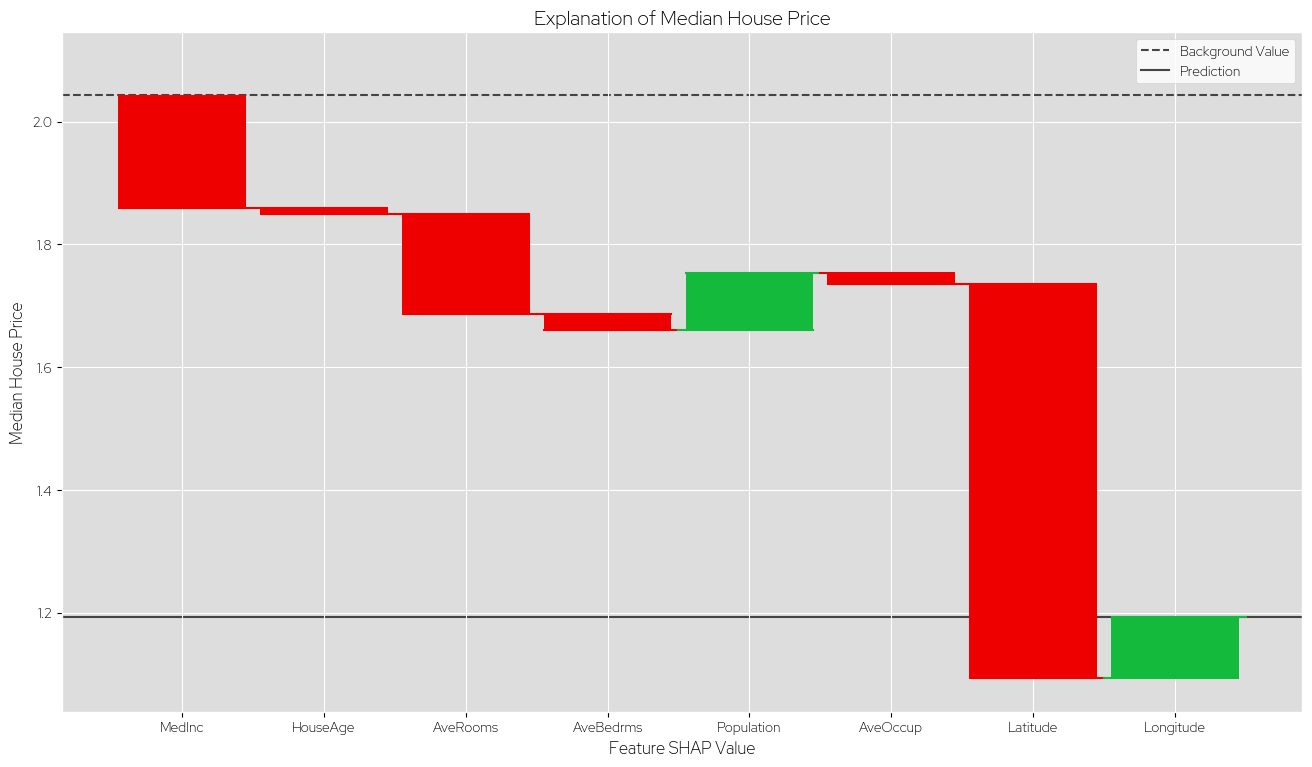

In [355]:
def visualize_explanations_as_candlestick(explanations):
    plt.style.use('https://raw.githubusercontent.com/RobGeada/stylelibs/main/material_rh.mplstyle')
    
    for i, saliency in enumerate(explanation.getSaliencies()):
        #background_mean_f_vals = np.mean([[f.getValue().asNumber() for f in pi.getFeatures()] for pi in background], 0).tolist()
        #f_vals = [pfi.getFeature().getValue().asNumber() for pfi in saliency.getPerFeatureImportance()]
        shap_vals = [pfi.getScore() for pfi in saliency.getPerFeatureImportance()]
        feature_names = [str(pfi.getFeature().getName()) for pfi in saliency.getPerFeatureImportance()]
        fnull = explanation.getFnull().getEntry(i)
        prediction = fnull+sum(shap_vals)
        plt.figure()
        pos = fnull
        min_range, max_range = fnull-fnull*.05, fnull+fnull*.05
        for j in range(len(shap_vals)):
            color = '#ee0000' if shap_vals[j]<0 else "#13ba3c"
            width=.9
            if j>0:
                plt.plot([j-.5, j+width/2*.99], [pos, pos], color=color)
            plt.bar(j, height=shap_vals[j], bottom=pos, color=color, width=width)
            pos += shap_vals[j]
            plt.plot([j-width/2*.99, j+.5], [pos, pos], color=color)
            
            if pos < min_range:
                min_range = pos - pos*.05
            if pos > max_range:
                max_range = pos + pos*.05
        plt.axhline(fnull, color="#444444", linestyle="--",zorder=0, label='Background Value')
        plt.axhline(prediction, color="#444444", zorder=0, label='Prediction')
        plt.legend()
        plt.ylim(min_range, max_range)
        plt.xticks(np.arange(len(feature_names)), feature_names)
        plt.ylabel(saliency.getOutput().getName())
        plt.xlabel("Feature SHAP Value")
        plt.title(f"Explanation of {saliency.getOutput().getName()}")
        plt.show()
        
visualize_explanations_as_candlestick(explanations) 